In [1]:
%matplotlib inline
import random, pylab, math, numpy, os
import mpl_toolkits.mplot3d

In this homework set, you will study the local Metropolis, the heatbath and the Cluster Monte Carlo algorithms for the two-dimensional Ising model on a square lattice with periodic boundary conditions. At the end of the homework session, you will have validated all three programs against known analytic results. furthermore, you will have compared the results to a classic result of Ferdinand and Fisher, from 1969, analyzed the time-behavior of the cluster algorithm of Wolff (1989), and started to understand Propp and Wilson's coupling from the past approach.

# A

## A1

Here, you implement the local Metropolis algorithm, and validate it through the comparison with an
exactly known result. In a real-life application, this validation would run for many days on a computer, to establish agreement with the exact result to 5 or 6 significant digits.

The local Metropolis algorithm for the Ising model is given below.

In [9]:
def energy(S, N, nbr):
    E = 0.0
    for k in range(N):
        E -= S[k] * sum(S[nn] for nn in nbr[k])
    return 0.5 * E

L = 6
N = L * L
nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N) 
       for i in range(N)}

T = 2.0
filename = 'local_'+ str(L) + '_' + str(T) + '.txt'
nsteps = N * 100000
beta = 1.0 / T
E_means = []

for i in xrange(4):
    S = [random.choice([1, -1]) for k in range(N)]
    Energy = energy(S, N, nbr)
    E = []
    for step in range(nsteps):
        k = random.randint(0, N - 1)
        delta_E = 2.0 * S[k] * sum(S[nn] for nn in nbr[k])
        if random.uniform(0.0, 1.0) < math.exp(-beta * delta_E):
            S[k] *= -1
            Energy += delta_E
        E.append(Energy)
    E_means.append(sum(E)/len(E)/N)
    print sum(E) / len(E) / N, 'mean energy run %i'%(i)
print "Mean value from %i independent runs = %f"%(i, sum(E_means)/len(E_means))

-1.74534651235 mean energy run 0
-1.74647148148 mean energy run 1
-1.74721592593 mean energy run 2
-1.75044141975 mean energy run 3
Mean value from 3 independent runs = -1.747369


Greatly increase the number of iterations of the algorithm.

Run it for L=6 and for T = 2.0.

The exact value is known from exact enumeration: E/N =-1.747

# QUESTION

1.  Communicate the results obtained in four independent runs of the algorithms (no calculation of error bars required).

From four independent runs we obtain exact value of approximate energy per spin to roughly second decimal place with mean value of E/N = -1.747369.

<font color='red'>Correct</font> 2/2 pts.

## A2

Modify your program so that it allows you to read in and write out configurations and also to print configurations on the screen. For simplicity, this program is provided, you are free run and modify it.

In [10]:
def x_y(k, L):
    y = k // L
    x = k - y * L
    return x, y

L = 128
N = L * L
nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N)
       for i in range(N)}

T = 1.0
filename = 'local_'+ str(L) + '_' + str(T) + '.txt'
if os.path.isfile(filename):
    f = open(filename, 'r')
    S = []
    for line in f:
        S.append(int(line))
    f.close()
    print 'starting from file', filename
else:
    S = [random.choice([1, -1]) for k in range(N)]
    print 'starting from scratch'
    
nsteps = N * 100
beta = 1.0 / T

for step in range(nsteps):
    k = random.randint(0, N - 1)
    delta_E = 2.0 * S[k] * sum(S[nn] for nn in nbr[k])
    if random.uniform(0.0, 1.0) < math.exp(-beta * delta_E):
        S[k] *= -1
        

conf = [[0 for x in range(L)] for y in range(L)]
for k in range(N):
    x, y = x_y(k, L)
    conf[x][y] = S[k]

starting from scratch


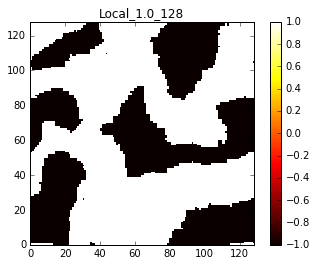

In [11]:
pylab.imshow(conf, extent = [0, L, 0, L], interpolation='nearest')
pylab.set_cmap('hot')
pylab.colorbar()
pylab.title('Local_'+ str(T) + '_' + str(L))
pylab.savefig('Local_'+ str(T) + '_' + str(L)+ '.png')
pylab.show()
f = open(filename, 'w')
for a in S:
    f.write(str(a) + '\n')
f.close()

In [12]:
def localMetropolis(L, T, modifier):
    N = L * L
    nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
                (i // L) * L + (i - 1) % L, (i - L) % N)
           for i in range(N)}

    filename = 'local_'+ str(L) + '_' + str(T) + '.txt'
    if os.path.isfile(filename):
        f = open(filename, 'r')
        S = []
        for line in f:
            S.append(int(line))
        f.close()
        print 'starting from file', filename
    else:
        S = [random.choice([1, -1]) for k in range(N)]
        print 'starting from scratch'
    
    nsteps = N * modifier
    beta = 1.0 / T

    for step in range(nsteps):
        k = random.randint(0, N - 1)
        delta_E = 2.0 * S[k] * sum(S[nn] for nn in nbr[k])
        if random.uniform(0.0, 1.0) < math.exp(-beta * delta_E):
            S[k] *= -1
        

    conf = [[0 for x in range(L)] for y in range(L)]
    for k in range(N):
        x, y = x_y(k, L)
        conf[x][y] = S[k]
    pylab.imshow(conf, extent = [0, L, 0, L], interpolation='nearest')
    pylab.set_cmap('hot')
    pylab.colorbar()
    pylab.title('Local_'+ str(T) + '_' + str(L))
    pylab.savefig('Local_'+ str(T) + '_' + str(L)+ '.png')
    pylab.show()
    f = open(filename, 'w')
    for a in S:
        f.write(str(a) + '\n')
    f.close()


Configuration after 200 runs
starting from scratch


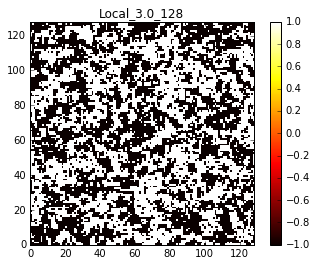

Configuration after 400 runs
starting from file local_128_3.0.txt


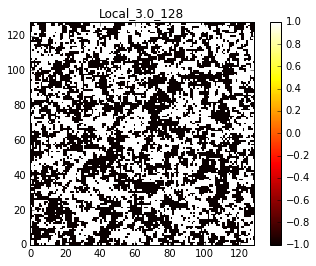

Configuration after 600 runs
starting from file local_128_3.0.txt


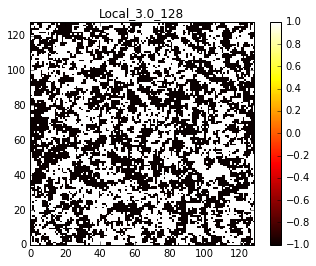

Configuration after 800 runs
starting from file local_128_3.0.txt


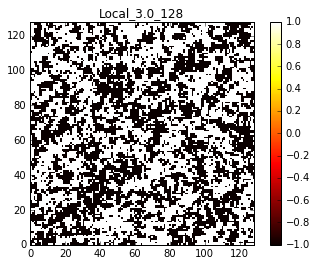

Configuration after 1000 runs
starting from file local_128_3.0.txt


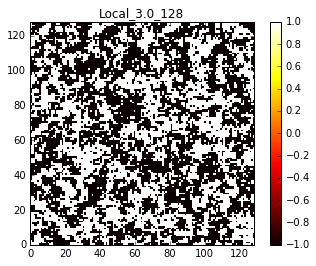

Configuration after 1200 runs
starting from file local_128_3.0.txt


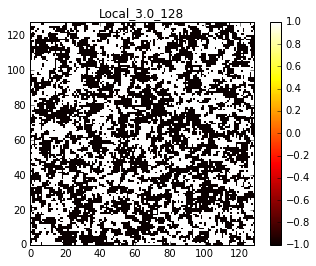

Configuration after 1400 runs
starting from file local_128_3.0.txt


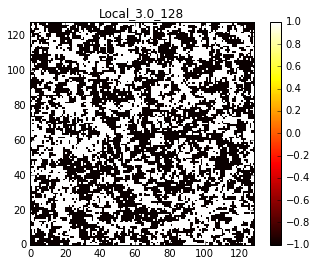

Configuration after 1600 runs
starting from file local_128_3.0.txt


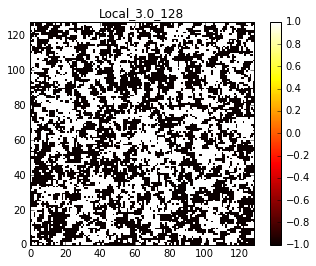

Configuration after 1800 runs
starting from file local_128_3.0.txt


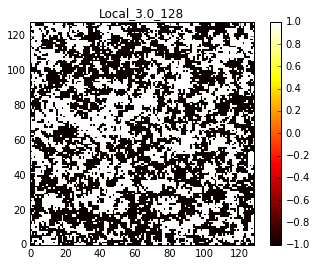

In [19]:
modifier = 200
for sweep in xrange(1, 10):
    print "Configuration after %i runs"%(sweep*modifier)
    localMetropolis(128, 3.0, modifier)

starting from file local_128_2.27.txt


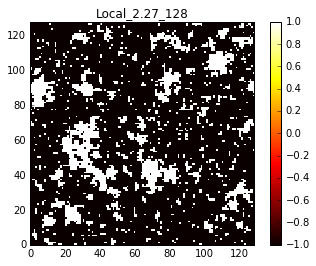

starting from file local_128_2.27.txt


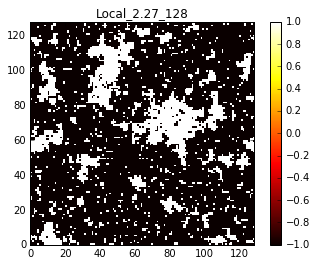

starting from file local_128_2.27.txt


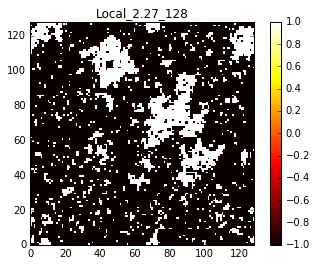

starting from file local_128_2.27.txt


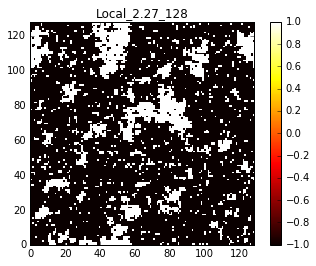

starting from file local_128_2.27.txt


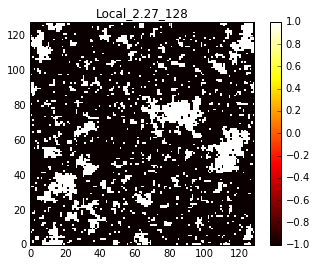

starting from file local_128_2.27.txt


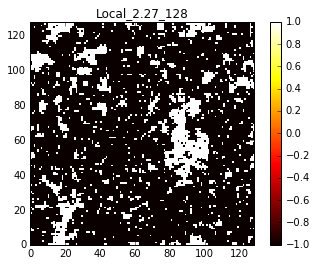

starting from file local_128_2.27.txt


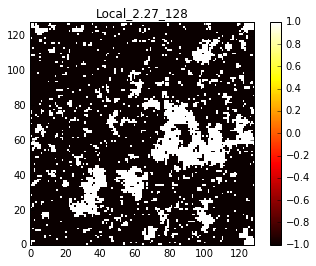

starting from file local_128_2.27.txt


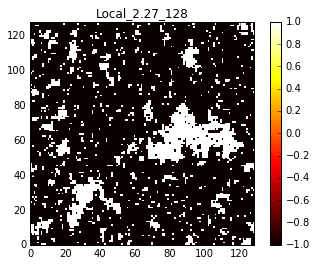

starting from file local_128_2.27.txt


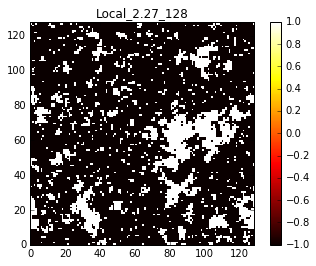

In [24]:
modifier = 200
for sweep in xrange(1, 10):
    #print "Configuration after %i runs"%(sweep*modifier)
    localMetropolis(128, 2.27, modifier)

starting from scratch


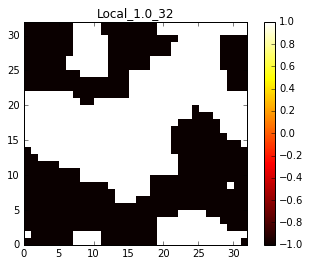

starting from file local_32_1.0.txt


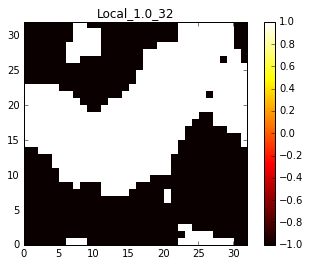

starting from file local_32_1.0.txt


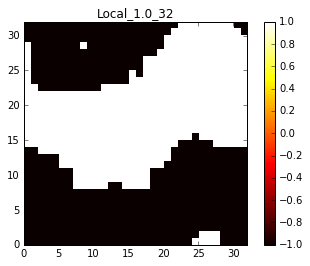

starting from file local_32_1.0.txt


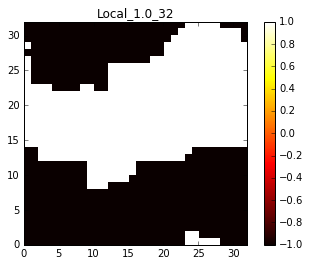

starting from file local_32_1.0.txt


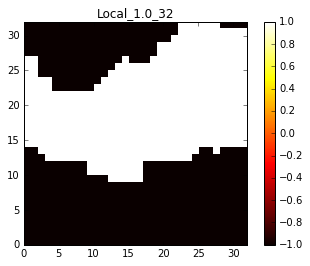

starting from file local_32_1.0.txt


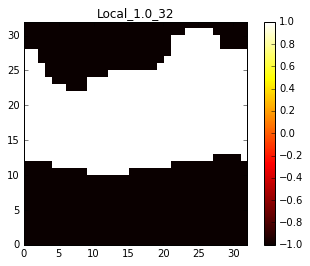

starting from file local_32_1.0.txt


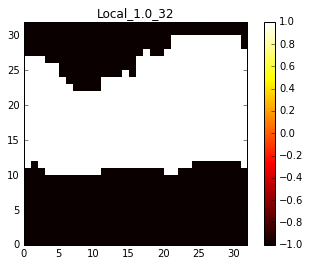

starting from file local_32_1.0.txt


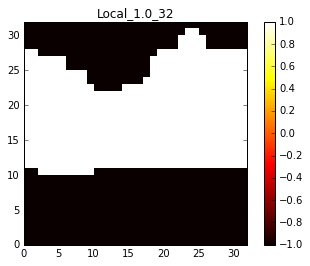

starting from file local_32_1.0.txt


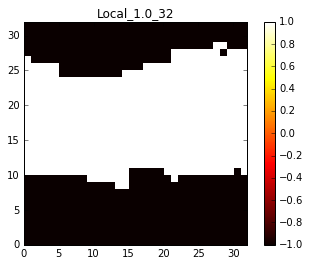

starting from file local_32_1.0.txt


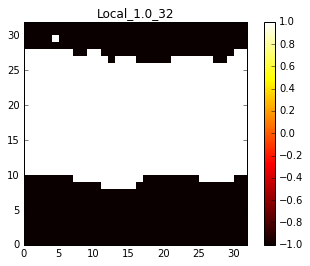

starting from file local_32_1.0.txt


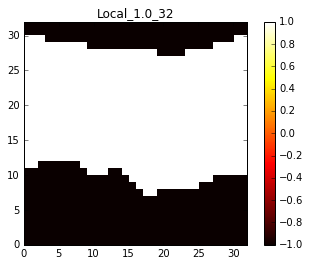

starting from file local_32_1.0.txt


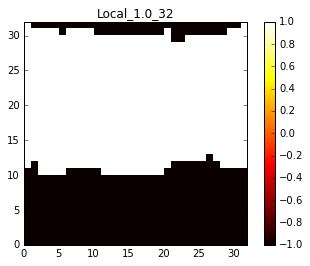

starting from file local_32_1.0.txt


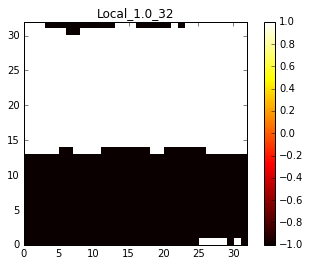

starting from file local_32_1.0.txt


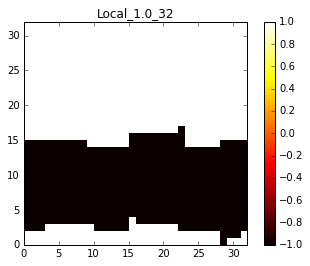

starting from file local_32_1.0.txt


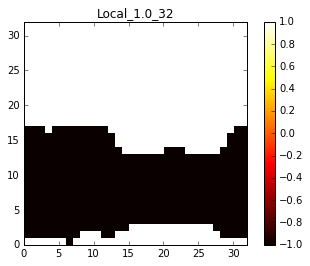

starting from file local_32_1.0.txt


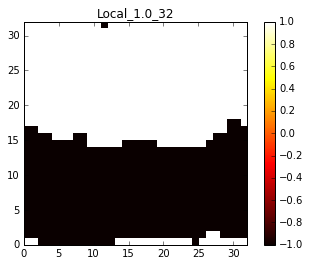

starting from file local_32_1.0.txt


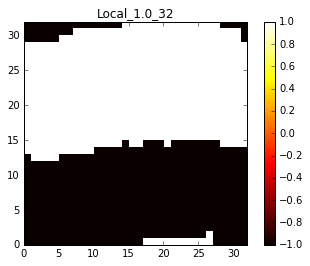

starting from file local_32_1.0.txt


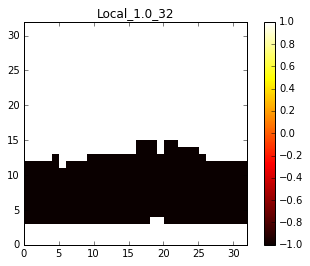

starting from file local_32_1.0.txt


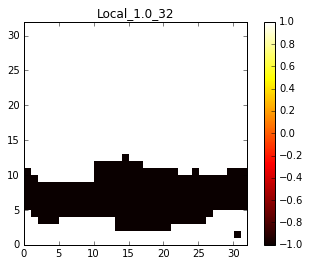

starting from file local_32_1.0.txt


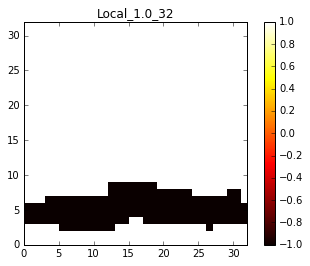

starting from file local_32_1.0.txt


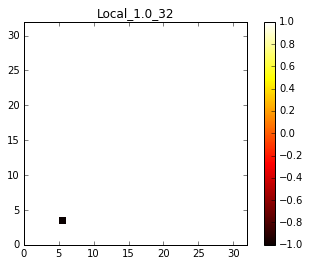

starting from file local_32_1.0.txt


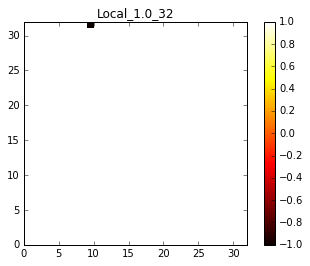

starting from file local_32_1.0.txt


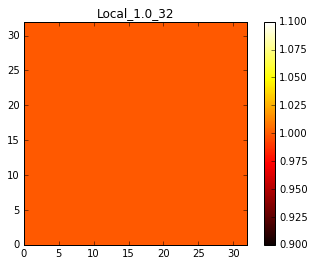

starting from file local_32_1.0.txt


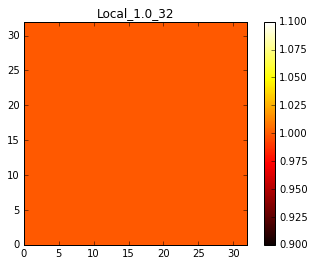

starting from file local_32_1.0.txt


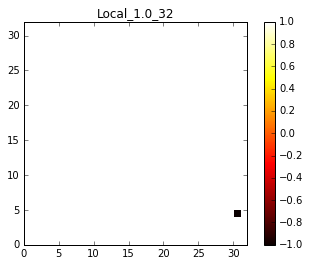

starting from file local_32_1.0.txt


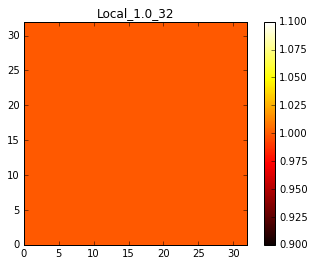

starting from file local_32_1.0.txt


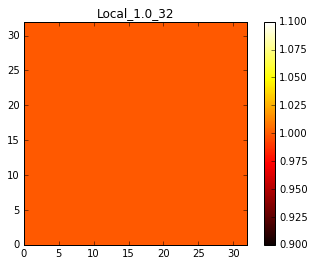

In [25]:
modifier = 10
for sweep in xrange(1, 10):
    #print "Configuration after %i runs"%(sweep*modifier)
    localMetropolis(32, 1.0, modifier)

modifier = 100
for sweep in xrange(1, 10):
    #print "Configuration after %i runs"%(sweep*modifier)
    localMetropolis(32, 1.0, modifier)

modifier = 1000
for sweep in xrange(1, 10):
    #print "Configuration after %i runs"%(sweep*modifier)
    localMetropolis(32, 1.0, modifier)

starting from file local_32_1.0.txt


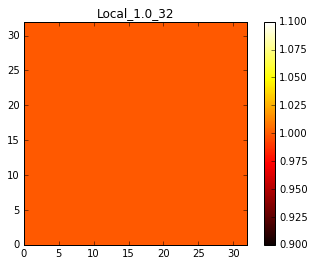

starting from file local_32_1.0.txt


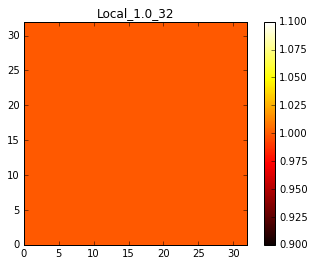

starting from file local_32_1.0.txt


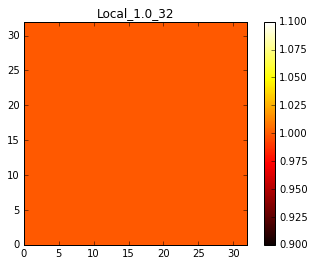

starting from file local_32_1.0.txt


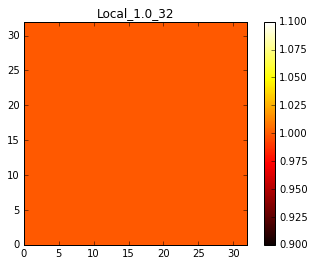

starting from file local_32_1.0.txt


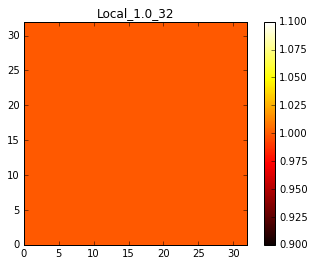

starting from file local_32_1.0.txt


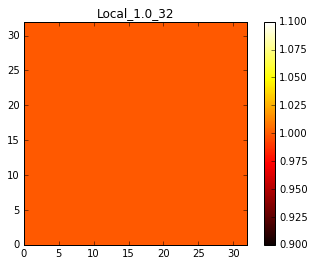

starting from file local_32_1.0.txt


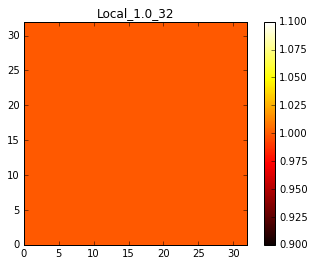

starting from file local_32_1.0.txt


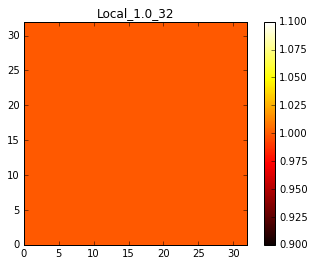

starting from file local_32_1.0.txt


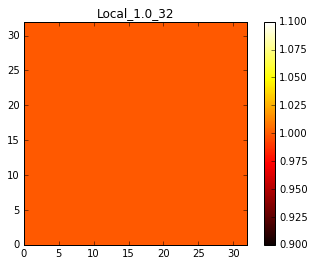

In [26]:
modifier = 10000
for sweep in xrange(1, 10):
    #print "Configuration after %i runs"%(sweep*modifier)
    localMetropolis(32, 1.0, modifier)

starting from file local_128_1.0.txt


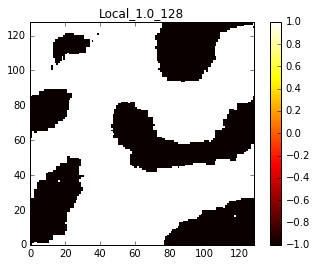

starting from file local_128_1.0.txt


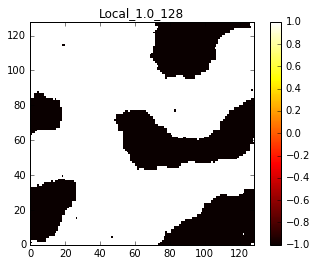

starting from file local_128_1.0.txt


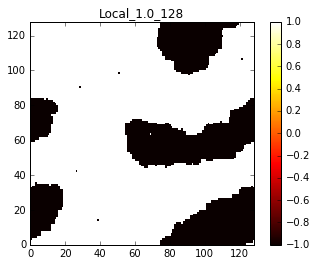

starting from file local_128_1.0.txt


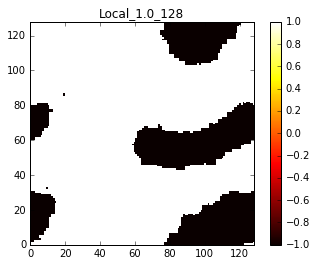

starting from file local_128_1.0.txt


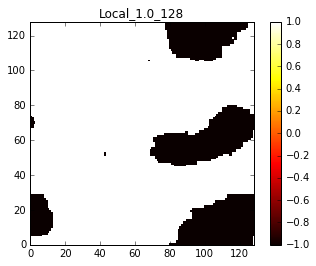

starting from file local_128_1.0.txt


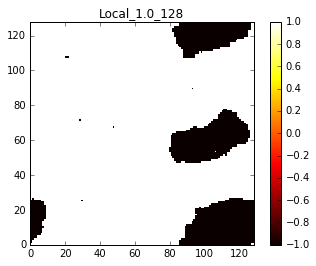

starting from file local_128_1.0.txt


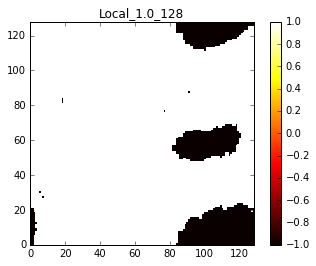

starting from file local_128_1.0.txt


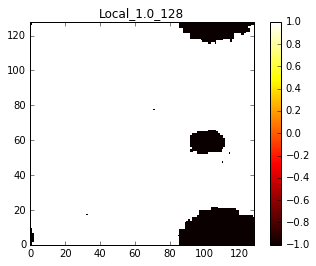

starting from file local_128_1.0.txt


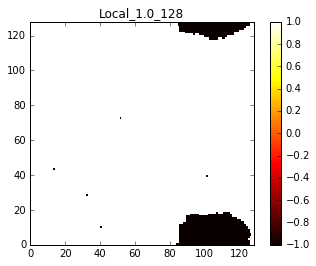

In [27]:
modifier = 100
for sweep in xrange(1, 10):
    #print "Configuration after %i runs"%(sweep*modifier)
    localMetropolis(128, 1.0, modifier)

starting from file local_128_1.0.txt


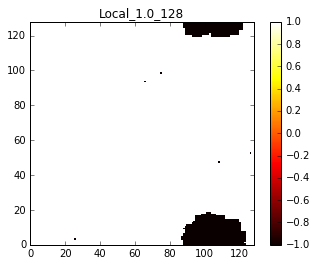

starting from file local_128_1.0.txt


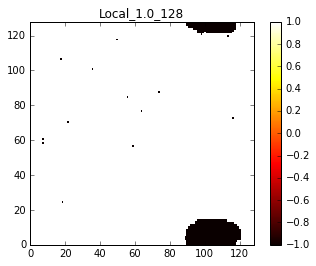

starting from file local_128_1.0.txt


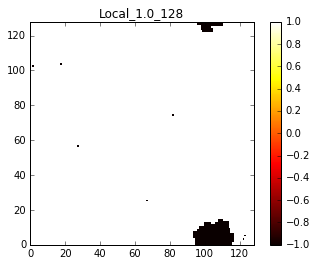

starting from file local_128_1.0.txt


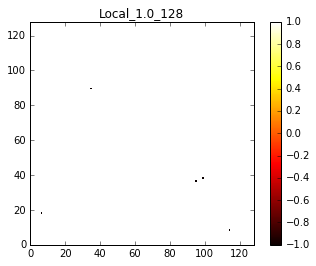

In [29]:
modifier = 100
for sweep in xrange(1, 5):
    #print "Configuration after %i runs"%(sweep*modifier)
    localMetropolis(128, 1.0, modifier)

starting from file local_128_1.0.txt


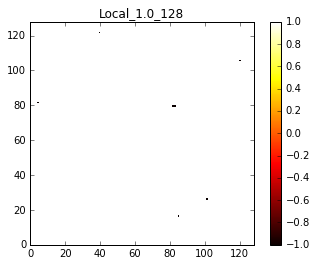

starting from file local_128_1.0.txt


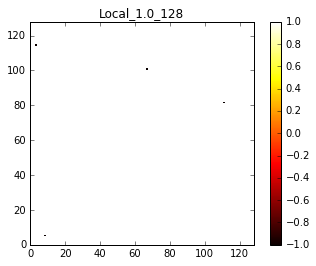

starting from file local_128_1.0.txt


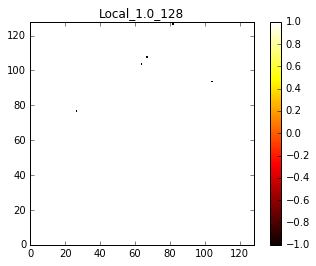

starting from file local_128_1.0.txt


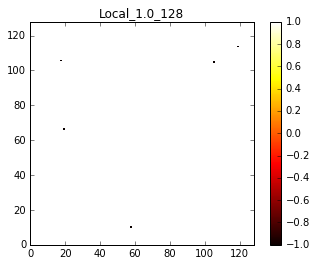

In [31]:
modifier = 500
for sweep in xrange(1, 5):
    #print "Configuration after %i runs"%(sweep*modifier)
    localMetropolis(128, 1.0, modifier)

From a random initial configuration, run this program at high temperature $T = 3.0$ (L=128) and at the critical temperature $T_{crit} = 2.27$ (L=128). Run it for sufficiently long, so that you have reached what you would consider as the $t \to \infty$ limit. (At $T_{crit}$, you should run your code for at least a few minutes). Notice that subsequent runs of this program realize a Markov chain (i.e., three runs with 100 + 100 + 100 iterations = 1 run with 300 iterations).

# QUESTIONS

1. Display typical configurations that you have obtained and comment on what you see. 
2. At low temperature, T = 1.0, run your code for L=32, first for 10 N iterations, then again, several times for 10 N iterations, then several times for 100 N iterations (if you see a stripe, run your program longer, up to several ties 1000 N or several times 10000 N iterations). You should observe that, after a quite long time, your simulation goes from a state with domain walls into a purely ferromagnetic state (essentially all spins +1 or essentially all spins -1). Display two or three pictures at different times. Do you observe (running for several times 10000 N iterations) that the local Metropolis algorithm flips between configurations of negative overall magnetization (mostly black) and configurations of positive overall magnetization (mostly white)?
3. At low temperature, T = 1.0 (as before), run your code for L=128 and display a configuration. Explain what you observe. In particular, do you observe that the system becomes homogeneous (mostly white or mostly black) on the available time scales?

## Answers

1. From above picture we can see striking diference in system magnetization for high temperatures spin orientation randomly oscilate and no prefered magnetization appear. While for lower temperatures at $T_{crit}$ we can see that spins starts to orient together and overall magnetization increase, howvever still not full aragment of spins was observed.

2. In this case we observerd transition into feromagnetic state however afterwards system got frozen in one state and local Metropolis algorithms seems to not be able to reverse magnetization (too high penality) even though in system withou externa field both magnetizations should be probable.

3. In this case we can observer spontaneous formation of clusters of spins, which slowly decrease in size and eventualy whole system is composed primarly by one orientation of spins.

<font color='red'>Correct</font> 5/5 pts.

# B

In this section, you run the Wolff cluster algorithm, one of the great (but little understood) algorithms of statistical physics.

## B1

The Wolff cluster Monte Carlo algorithm for the Ising model is implemented below.

Familiarize yourself with how it works before going on. Explain in a few words what the Pocket stands for.

### Answer
Just as in other cluster algorithms Pocket is set of spins that are selected as possible candidates for being added to cluster, while cluster contan spins that are going to be changed as group.

In [39]:
def energy(S, N, nbr):
    E = 0.0
    for k in range(N):
        E -= S[k] * sum(S[nn] for nn in nbr[k])
    return 0.5 * E

L = 6
N = L * L
nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N)
       for i in range(N)}

T = 2.0
p = 1.0 - math.exp(-2.0 / T)
nsteps = 100000

for sweep in xrange(4):
    S = [random.choice([1, -1]) for k in range(N)]
    E = [energy(S, N, nbr)]
    for step in range(nsteps):
        k = random.randint(0, N - 1)
        Pocket, Cluster = [k], [k]
        while Pocket != []:
            j = random.choice(Pocket)
            for l in nbr[j]:
                if S[l] == S[j] and l not in Cluster and random.uniform(0.0, 1.0) < p:
                    Pocket.append(l)
                    Cluster.append(l)
            Pocket.remove(j)
        for j in Cluster:
            S[j] *= -1
        E.append(energy(S, N, nbr))
    print sum(E)/ len(E) / N

-1.74866695777
-1.74703808517
-1.74797696467
-1.74721697227


In [38]:
print "With pocket.pop()"
for sweep in xrange(4):
    S = [random.choice([1, -1]) for k in range(N)]
    E = [energy(S, N, nbr)]
    for step in range(nsteps):
        k = random.randint(0, N - 1)
        Pocket, Cluster = [k], [k]
        while Pocket != []:
            j = Pocket.pop()
            for l in nbr[j]:
                if S[l] == S[j] and l not in Cluster and random.uniform(0.0, 1.0) < p:
                    Pocket.append(l)
                    Cluster.append(l)
        for j in Cluster:
            S[j] *= -1
        E.append(energy(S, N, nbr))
    print sum(E)/ len(E) / N

With pocket.pop()
-1.74630142587
-1.74612476097
-1.74783474387
-1.74853140357


Greatly increase the number of iterations of the algorithm. 

Run it for L=6 and T = 2.0.

Check that you recover the exact value for the mean energy $E/N(T=2, L=6) = -1.747$ (known from exact enumeration).

# QUESTIONS

1. Communicate the results obtained in four independent runs of the algorithms.
2. Is it necessary to pick a random element j of the pocket (element that we eliminate from the pocket through Pocket.remove(j)), or can we simply pop the last element of Pocket (j = Pocket.pop())?
3. Modify then run the program modified according to the suggestion of the preceding question (note that it has one less line, the Pocket.remove() line is no longer needed), and explain your observations.

## Answer

1. Well just as in local Metropolis algorithm we obtained valeu E/N(T=2,L=6) o two decimal places.

2. Well since .pop() is just .remove() which also return value that was removed we can change code.

3. There is no significat cahnge in accurency of mean energy per spin prediction while overall code is slightly faster.

<font color='red'>Correct</font> 3/3 pts.

## B2 

The Ising model was solved exactly by Onsager, in 1944, for the infinite lattice. The exact solution for the finite lattice was obtained by Kaufman in 1949 . Based on her paper, Ferdinand and Fisher, in 1969, computed the specific heat for finite lattices with periodic boundary conditions, exactly the system that we consider, and the result is shown in Fig1 of their paper, which you will find in your repo, in the "Figures" folder below the current one.

Incorporate into the cluster algorithm the read-in, write-out part of section A2, which allows you to do a 'warm start' (that is, discard some initial data). Run this modified cluster algorithm for lattices of size L=2, 4, 8, 16, 32 and check Ferdinand and Fisher's analytical results. To do so, implement a few lines analogous to:

In [ ]:
E_mean = sum(E)/ len(E)
E2_mean = sum(a ** 2 for a in E) / len(E)
cv = (E2_mean - E_mean ** 2 ) / N / T ** 2

In [42]:
def wolffCluster(L, T, modifier):
    N = L * L
    nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
                (i // L) * L + (i - 1) % L, (i - L) % N)
           for i in range(N)}

    p = 1.0 - math.exp(-2.0 / T)
    
    ## Read termalized configuration if possible
    filename = 'wolff_'+ str(L) + '_' + str(T) + '.txt'
    if os.path.isfile(filename):
        f = open(filename, 'r')
        S = []
        for line in f:
            S.append(int(line))
        f.close()
        print 'starting from file', filename
    else:
        S = [random.choice([1, -1]) for k in range(N)]
        print 'starting from scratch'
    
    E = [energy(S, N, nbr)]
    nsteps = N * modifier
    
    for step in range(nsteps):
        k = random.randint(0, N - 1)
        Pocket, Cluster = [k], [k]
        while Pocket != []:
            j = random.choice(Pocket)
            for l in nbr[j]:
                if S[l] == S[j] and l not in Cluster and random.uniform(0.0, 1.0) < p:
                    Pocket.append(l)
                    Cluster.append(l)
            Pocket.remove(j)
        for j in Cluster:
            S[j] *= -1
        E.append(energy(S, N, nbr))
    E_mean = sum(E)/ len(E)
    E2_mean = sum(a ** 2 for a in E) / len(E)
    cv = (E2_mean - E_mean ** 2 ) / N / T ** 2

    #write termalized configuration
    f = open(filename, 'w')
    for a in S:
        f.write(str(a) + '\n')
    f.close()
    
    return [E_mean, cv]


In [46]:
L = [2, 4, 8, 16, 32]
modifier = 10
cv_dict = {}

for l in L:
    # termalization
    for sweep in xrange(1):
        wolffCluster(l, 2.27, modifier)
    # sample run
    E_mean, cv = wolffCluster(l, 2.27, modifier )
    print "CV for %i x %i latice at reduced temperature T = 2.27 is : %f"%(l,l, cv)
    cv_dict.update({l:cv})


starting from file wolff_2_2.27.txt
starting from file wolff_2_2.27.txt
CV for 2 x 2 latice at reduced temperature T = 2.27 is : 0.387900
starting from file wolff_4_2.27.txt
starting from file wolff_4_2.27.txt
CV for 4 x 4 latice at reduced temperature T = 2.27 is : 0.874983
starting from file wolff_8_2.27.txt
starting from file wolff_8_2.27.txt
CV for 8 x 8 latice at reduced temperature T = 2.27 is : 1.137395
starting from file wolff_16_2.27.txt
starting from file wolff_16_2.27.txt
CV for 16 x 16 latice at reduced temperature T = 2.27 is : 1.485329
starting from file wolff_32_2.27.txt
starting from file wolff_32_2.27.txt
CV for 32 x 32 latice at reduced temperature T = 2.27 is : 1.893557


(Remember the definition of the specific heat given in class).

# QUESTION

1. Communicate your results (without error bars, just quote the results of one or two runs, after a warm start, for each value of the parameters) at the critical temperature T = 2.27.
NB: we just need rough agreement.
2. Can you confirm that observables such as the specific heat for the Ising model in the transition region exhibit a strong finite size effect?

## Answers

1. Results obtained from our simulation are in qualitative agreement with analytical theory and graphs shown in article whith quite suprising precision (at least to me).

2. Yes, we can see steep increse in height of cv peak at transition temperature with increase of lattice size.

<font color='red'>Correct</font> 3/3 pts. Indeed - our machines have become **that** much more powerful! :)

# C

In this section, you run the heatbath algorithm.

## C1

The heatbath algorithm for the Ising model is implemented in the cell below. Familiarize yourself with how it works.

In [50]:
L = 6
N = L * L
nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N) 
       for i in range(N)}

nsteps = N * 100000
T = 2.0
beta = 1.0 / T

for sweep in xrange(4):
    S = [random.choice([-1, 1]) for site in range(N)]
    E = -0.5 * sum(S[k] * sum(S[nn] for nn in nbr[k]) for k in range(N))
    Energies = []

    for step in range(nsteps):
        k = random.randint(0, N - 1)
        Upsilon = random.uniform(0.0, 1.0)
        h = sum(S[nn] for nn in nbr[k])
        Sk_old = S[k]
        S[k] = -1
        if Upsilon < 1.0 / (1.0 + math.exp(-2.0 * beta * h)):
            S[k] = 1
        if S[k] != Sk_old:
            E -= 2.0 * h * S[k]
        Energies.append(E)
    print sum(Energies) / len(Energies) / N

-1.74560777778
-1.74948401235
-1.74690012346
-1.7505829321


Greatly increase the number of iterations of the algorithm.

Run it for L=6 and for T = 2.0. Check that you recover the exact value for the mean energy E/N(T=2, L=6) = -1.747.

# QUESTION

1. Communicate the results obtained in four independent runs of the algorithm.

## Answer

1. In this case from four independent simulations we obtained mean energy per spin with lowver precision then in previous cases only at roughly one decimal place.

<font color='red'>Correct</font> 2/2 pts.

## C2 

Modify the heatbath algorithm so that it does **two** computations in parallel, as discussed during the lecture:
one starting from the all plus spin configuration, and one from the all minus configuration. For simplicity,
the implementation is provided. You are free run and modify it, but familiarize yourself thoroughly with this program.


In [54]:
L = 32
N = L * L
nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N)
       for i in range(N)}

t_coup_list = []
for T in [5.0, 4.0, 3.0, 2.5, 2.4,2.3]:
    beta = 1.0 / T
    t_coup = []
    for iter in range(10):
#        print iter
        S0 = [1] * N
        S1 = [-1] * N
        step = 0
        while True:
            step += 1
            k = random.randint(0, N - 1)
            Upsilon = random.uniform(0.0, 1.0)
            h = sum(S0[nn] for nn in nbr[k])
            S0[k] = -1
            if Upsilon < 1.0 / (1.0 + math.exp(-2.0 * beta * h)):
                S0[k] = 1
            h = sum(S1[nn] for nn in nbr[k])
            S1[k] = -1
            if Upsilon < 1.0 / (1.0 + math.exp(-2.0 * beta * h)):
                S1[k] = 1
            if step % N == 0:
                n_diff = sum(abs(S0[i] - S1[i]) for i in range(N))
                if n_diff == 0:
                    t_coup.append(step / N)
                    break
#    print t_coup
    print "Coupling time for T = %.1f : t_coupl = %i"%(T, sum(t_coup) / len(t_coup))
    t_coup_list.append(sum(t_coup) / len(t_coup))

Coupling time for T = 5.0 : t_coupl = 19
Coupling time for T = 4.0 : t_coupl = 40
Coupling time for T = 3.0 : t_coupl = 89
Coupling time for T = 2.5 : t_coupl = 376
Coupling time for T = 2.4 : t_coupl = 991
Coupling time for T = 2.3 : t_coupl = 4659


Compute the time (in number of "sweeps", i.e. in number of steps / N) at which the algorithm couples, that is, at which the difference between the configurations generated in one run and the other falls to zero. Plot this coupling time (averaged over 10 runs with different random numbers) for L = 32 at temperature T= 5.0, 4.0, 3.0, 2.5, 2.4, 2.3. **Attention**: run T=2.3 only if you have a lot of CPU time available...In the Ising model, the coupling time is, up to a logarithmic factor in N, equal to the correlation time, so this coupling time informs you of the order of magnitude of the correlation time. 

# QUESTIONS

1. Describe what you see.
2. Ferdinand and Fisher, in a footnote of their 1969 paper discussed earlier, compared their exact calculations with the earliest Monte Carlo calculations on the Ising model. Take a look at the footnote 20 in the paper, p841. In the light of your exact bounds on the correlation time, can you explain the insufficient agreement between theory and numerics reported by Ferdinand and Fisher?

## Answers

1. We can see how coupling time rapidly increase with decrease in temperature as we move to transition temperature, that means we need to simulate much longer to get uncorrelated samples.

2. Well problem might be in long corelation times which means much longer simulations have to be done which might be problematic in early Monte Carlo experiments. So that source of errors might be from fact that samples used in their calculations were highly correlate.

<font color='red'>Correct</font> 3/3 pts. Exactly! :)

The algorithm in C2 couples, and its coupling time provides a rigorous limit on the convergence time. Nevertheless, the configuration obtained is not really a random configuration, simply because the coupling time itself has fluctuations. For your information and enjoyment, we provide here a rudimentary yet exact algorithm following the "coupling from the past principle" that, rather than simulating from time t=0 to a coupling time t_coup, mimicks a simulation from $t= -\infty$ to $t=0$.

In [64]:
L = 16
N = L * L
nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N) 
       for i in range(N)}

nsteps = 10
T = 3.0
beta = 1.0 / T
S0 = [1] * N
S1 = [-1] * N
k = {}
Upsilon = {}
n_diff = 10

while n_diff != 0:
    nsteps *= 2
    for step in range(-nsteps, 0):
        if step not in k:
            k[step] = random.randint(0, N - 1)
            Upsilon[step] = random.uniform(0.0, 1.0)
        h = sum(S0[nn] for nn in nbr[k[step]])
        S0[k[step]] = -1
        if Upsilon[step] < 1.0 / (1.0 + math.exp(-2.0 * beta * h)):
            S0[k[step]] = 1
        h = sum(S1[nn] for nn in nbr[k[step]])
        S1[k[step]] = -1
        if Upsilon[step] < 1.0 / (1.0 + math.exp(-2.0 * beta * h)):
            S1[k[step]] = 1
    n_diff = 0
    for i in range(N):
        if S0[i] != S1[i]: 
            n_diff += 1
    print nsteps, n_diff

20 253
40 252
80 250
160 241
320 216
640 186
1280 134
2560 82
5120 9
10240 2
20480 0


The configuration at t=0 is a perfect sample, following the coupling from the past idea of Propp and
Wilson (1996). You can see that an infinite simulation, from t = -infty up to t = 0, would output the sample
at t=0.


# QUESTION

Np points, no question asked - purely for scientific interest.

Thank you for interesting homework!

<font color='red'>Grand Total</font> 18/18 pts. Thank **you** for a doing a great job of it :)